# TPI-DeepTDA: Chignolin mini-protein

Reference paper: _Ray, Trizio and Parrinello, [JCP](https://pubs.aip.org/aip/jcp/article/158/20/204102/2891484) (2023)_ [[arXiv]](https://arxiv.org/abs/2303.01629).

Prerequisite: DeepTDA tutorial.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/example/ex_TPI-DeepTDA.ipynb)

## Setup

In [3]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)

## Transition State Informed Deep-TDA (TPI-DeepTDA)

We will use the folding of Chignolin protein as an example for the application of TPI-Deep-TDA as presented in [TPI-Deep-TDA paper](https://pubs.aip.org/aip/jcp/article/158/20/204102/2891484). As descriptors we will use the contacts between the $\alpha$-carbon of the protein chain.

In [4]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/dhimanray/TPI_deepTDA/main/chignolin/training/folded/contacts_folded_25000", 
              "https://raw.githubusercontent.com/dhimanray/TPI_deepTDA/main/chignolin/training/flooding/Contact_CV/contacts_ts_data",
              "https://raw.githubusercontent.com/dhimanray/TPI_deepTDA/main/chignolin/training/unfolded/contacts_unfolded_25000"]

n_states = len(filenames)

# load dataset
# here we only load part of the data to speed up the training, change stop to 25000 and stride to 1 to use them all for better results
dataset, df = create_dataset_from_files(filenames,
                                        create_labels=True,
                                        return_dataframe=True,
                                        filter_args={'regex':'cont' }, # select distances between heavy atoms
                                        stop=10000,
                                        stride=2)

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5000, 47)
Class 1 dataframe shape:  (5000, 47)
Class 2 dataframe shape:  (5000, 47)

 - Loaded dataframe (15000, 47): ['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'cont15', 'cont16', 'cont17', 'cont18', 'cont19', 'cont20', 'cont21', 'cont22', 'cont23', 'cont24', 'cont25', 'cont26', 'cont27', 'cont28', 'cont29', 'cont30', 'cont31', 'cont32', 'cont33', 'cont34', 'cont35', 'cont36', 'cont37', 'cont38', 'cont39', 'cont40', 'cont41', 'cont42', 'cont43', 'cont44', 'cont45', 'walker', 'labels']
 - Descriptors (15000, 45): ['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'cont15', 'cont16', 'cont17', 'cont18', 'cont19', 'cont20', 'cont21', 'cont22', 'cont23', 'cont24', 'cont25', 'cont26', 'cont27', 'cont28', 'cont29', 'cont30', 'cont31', 'cont32', 'cont33', 'cont34', 'cont35', 'cont36', 'cont37', 'co

### Model
Here we use as target a series of three consecutive Gaussians, the second one will be broader as it is related to the TPE data 

In [5]:
from mlcolvar.cvs import DeepTDA

n_cvs = 1
target_centers = [-7,0,7]
target_sigmas = [0.2, 1.5, 0.2]
nn_layers = [45,24,12,1]
# MODEL
model = DeepTDA(n_states=n_states, n_cvs=1,target_centers=target_centers, target_sigmas=target_sigmas, layers=nn_layers)

We initialize the `lightining.Trainer` and `Fit` the model.

In [6]:
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()

# define trainer
# for better results we can also increase the number of epochs or use a early_stopping
trainer = lightning.Trainer(callbacks=[metrics],
                     max_epochs=500, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [45]     | [45]     
2 | nn      | FeedForward   | 1.4 K  | [45]     | [1]      
-----------------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


/Users/luigi/opt/anaconda3/envs/pytorch13/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s, v_num=4]

/Users/luigi/opt/anaconda3/envs/pytorch13/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Learning curve

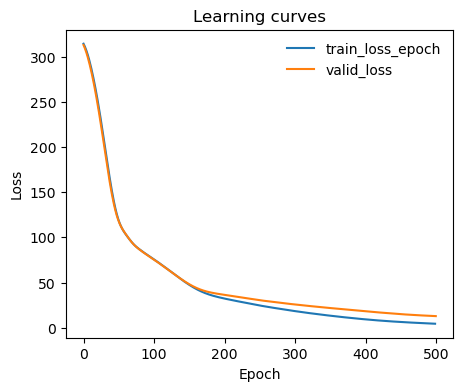

In [ ]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Analysis of the CV

The histogram of the training data along th CVs should match the target distribution 

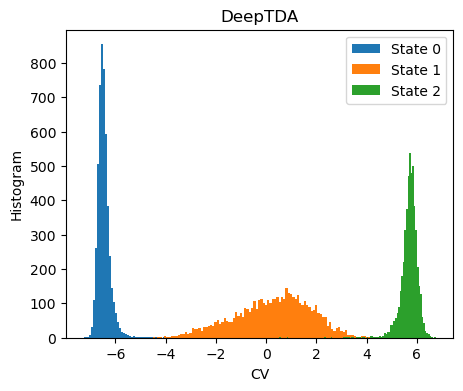

In [ ]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, label=f'State {i}')

ax.set_xlabel(f'CV')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()